# Код реалізації завдання 2
Import libraries


In [11]:
import numpy as np
from math import sqrt
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import Image

from labs.helpers import read_dataset

Prepare to load data

In [2]:
data_dir = "../../data/train"
classes = ["field", "road", "town", "water"]
file_pattern = "*{}*.jpg"
standard_shape = (50, 50, 3)

Load data and split it to train and test datasets

In [3]:
dataset, features = read_dataset(data_dir, classes, file_pattern, standard_shape)
train_df = dataset.sample(frac=0.85, random_state=18)
test_df = dataset.drop(train_df.index)

Demonstrate datasets

In [4]:
train_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
36,36.0,72.0,72.0,39.0,75.0,75.0,42.0,78.0,78.0,44.0,...,39.0,74.0,76.0,43.0,78.0,80.0,41.0,76.0,78.0,water
26,165.0,187.0,114.0,176.0,202.0,137.0,152.0,186.0,136.0,89.0,...,142.0,185.0,105.0,134.0,172.0,99.0,115.0,153.0,80.0,town
28,228.0,213.0,154.0,228.0,216.0,156.0,230.0,222.0,160.0,231.0,...,250.0,249.0,218.0,251.0,249.0,226.0,251.0,249.0,226.0,town
37,152.0,180.0,121.0,149.0,177.0,118.0,148.0,173.0,115.0,148.0,...,54.0,86.0,85.0,56.0,88.0,87.0,56.0,88.0,87.0,water
16,131.0,150.0,104.0,117.0,139.0,90.0,119.0,144.0,89.0,128.0,...,129.0,169.0,98.0,129.0,166.0,99.0,129.0,166.0,99.0,road


In [5]:
test_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
2,187.0,208.0,133.0,184.0,205.0,130.0,181.0,202.0,127.0,180.0,...,145.0,179.0,92.0,143.0,179.0,92.0,143.0,179.0,92.0,field
5,196.0,207.0,131.0,194.0,205.0,129.0,190.0,200.0,127.0,186.0,...,174.0,186.0,114.0,174.0,192.0,116.0,174.0,192.0,116.0,field
8,137.0,171.0,87.0,139.0,173.0,89.0,141.0,175.0,91.0,143.0,...,150.0,184.0,107.0,149.0,183.0,109.0,148.0,182.0,108.0,field
19,204.0,216.0,142.0,197.0,208.0,130.0,190.0,202.0,120.0,187.0,...,178.0,188.0,101.0,166.0,189.0,101.0,165.0,188.0,100.0,road
24,201.0,201.0,129.0,202.0,201.0,134.0,203.0,201.0,140.0,209.0,...,207.0,199.0,162.0,205.0,209.0,150.0,207.0,211.0,152.0,town


Python class that realizes learning and prediction operations

In [6]:
class Classifier:

    head = None
    __features = None
    __classes_centers = None
    __radius = None
    __next_level_predictor = None

    def __init__(self, head=True):
        self.head = head

    def fit(self, df, train_features, class_target, depth=5):
        self.__features = train_features
        self.__classes_centers = df.groupby(by=class_target).mean()[train_features]
        self.__radius = self.__calc_classes_radius(df, class_target)
        self.__next_level_predictor = self.__build_next_level_predict_action(df, class_target, depth)

    def __calc_classes_radius(self, df, class_target):
        radius = {}
        for class_name in self.__classes_centers.index:
            distances = []
            class_center = self.__classes_centers.loc[class_name].values
            class_df = df[df[class_target] == class_name]
            for measure_idx in class_df.index:
                measure = class_df.loc[measure_idx, self.__features].values
                measure_evclid_distance = self.__calc_evclid_distance(class_center, measure)
                distances.append(measure_evclid_distance)
            radius[class_name] = max(distances)
        return pd.DataFrame.from_dict(radius, orient="index", columns=["Radius"])

    def __build_next_level_predict_action(self, df, class_target, depth):
        uncertain_measures = self.__define_uncertain_measures(df)
        if depth != 0 and len(uncertain_measures) != 0:
            next_level_model = Classifier(head=False)
            next_level_model.fit(uncertain_measures, self.__features, class_target, depth - 1)
            return next_level_model.predict_class

    def __define_uncertain_measures(self, df):
        uncertain_measures_idxs = list()
        for measure_idx in df.index:
            measure = df.loc[measure_idx, self.__features].values
            measure_classes = self.__measure_belong_to_classes(measure)
            if len(measure_classes) > 1:
                uncertain_measures_idxs.append(measure_idx)
        return df.loc[uncertain_measures_idxs]

    def __measure_belong_to_classes(self, measure):
        owner_classes = list()
        for class_name in self.__classes_centers.index:
            class_center = self.__classes_centers.loc[class_name, self.__features].values
            evclid_dist = self.__calc_evclid_distance(measure, class_center)
            class_radius = self.__radius.loc[class_name, "Radius"]
            if evclid_dist < class_radius:
                owner_classes.append(class_name)
        return owner_classes

    @staticmethod
    def __calc_evclid_distance(measure1, measure2):
        difference = measure1 - measure2
        squared_diff = np.square(difference)
        sum_of_squared_diff = np.sum(squared_diff)
        return sqrt(sum_of_squared_diff)

    def predict(self, df):

        def iterate_test_df(measure_df):
            measure = measure_df.values
            return self.predict_class(measure)

        result = df[self.__features].apply(iterate_test_df, axis=1)
        return result

    def predict_class(self, measure):
        defined_classes = self.__measure_belong_to_classes(measure)
        defined_clases_number = len(defined_classes)
        if defined_clases_number == 1:
            return defined_classes[0]
        elif not self.__next_level_predictor is None:
            defined_class = self.__next_level_predictor(measure)
            if defined_class is None and self.head:
                return self.__predict_class_by_standard_method(measure)
            else:
                return defined_class
        elif not self.head:
            return None
        else:
            return self.__predict_class_by_standard_method(measure)

    def __predict_class_by_standard_method(self, measure):
        distances_to_classes = []
        for class_name in self.__classes_centers.index:
            class_standard = self.__classes_centers.loc[class_name].values
            evclid_dst = self.__calc_evclid_distance(measure, class_standard)
            distances_to_classes.append(evclid_dst)
        best_class_index = np.argmin(distances_to_classes)
        return self.__classes_centers.index[best_class_index]

Train the model and predict classes for test data

In [7]:
model = Classifier()
model.fit(train_df, features, "class")
pred_y = model.predict(test_df)

In [8]:
true_y = test_df["class"]
accuracy_score(true_y, pred_y)

1.0

Dependency of accuracy from number of features

Text(0, 0.5, 'Accuracy')

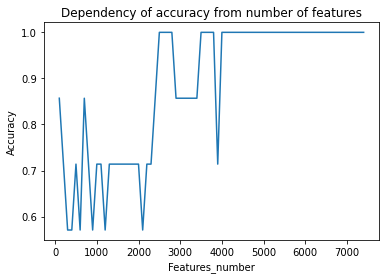

In [9]:
features_numbers = []
accuracy_values = []
for i in range(100, 7500, 100):
    local_features_to_use = features[:i]
    local_model = Classifier()
    local_model.fit(train_df, local_features_to_use, "class")
    local_predicted_classes = local_model.predict(test_df)
    local_acc = round(accuracy_score(true_y, local_predicted_classes), 3)
    features_numbers.append(i)
    accuracy_values.append(local_acc)

plt.plot(features_numbers, accuracy_values)
plt.title("Dependency of accuracy from number of features")
plt.xlabel("Features_number")
plt.ylabel("Accuracy")

Dependency of accuracy from number of classes

Text(0, 0.5, 'Accuracy')

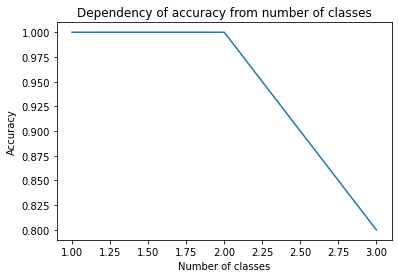

In [10]:
class_numbers = []
accuracy_values = []

for class_number in range(1, len(classes), 1):
    local_classes = classes[:class_number]
    local_dataset = dataset[dataset["class"].isin(local_classes)]
    local_train_df = local_dataset.sample(frac=0.85, random_state=18)
    local_test_df = local_dataset.drop(local_train_df.index)
    classes_local_model = Classifier()
    classes_local_model.fit(local_train_df, features, "class")
    local_predicted = classes_local_model.predict(local_test_df)
    real = local_test_df["class"].values
    acc_val = accuracy_score(real, local_predicted)
    class_numbers.append(class_number)
    accuracy_values.append(acc_val)

plt.plot(class_numbers, accuracy_values)
plt.title("Dependency of accuracy from number of classes")
plt.xlabel("Number of classes")
plt.ylabel("Accuracy")

Demonstrate some images

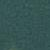

In [12]:
Image(filename=f"{data_dir}/water.jpg")

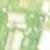

In [13]:
Image(filename=f"{data_dir}/town.jpg")

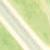

In [14]:
Image(filename=f"{data_dir}/road.jpg")

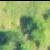

In [15]:
Image(filename=f"{data_dir}/field.jpg")

# Висновок

У даній роботі були взяті чотири різні види зображення(вода, місто, поле та ліс). Ці дані були перетворені на вектори
фіч та розподілені на вибірки для тренування та навчання. Для навчання використовувався метод еталонів, що дробляться із максимальною кількістю дроблень в 5 разів. Модель вказаного программного класу була навчена методом ```fit```. Для класифікації був використаний метод ```predict``` із вказаного программного класу. Модель показала точність 100%. Далі були проведені тести стосовно побудови моделей, що навчаються за різною кількістю ознак.
Як видно із малюнку графіку точність у вказаному тесті коливається від 25 до 100 відсотків. Зі збільшенням кількості ознак збільшувалася і точність розпізнавання.
Також був проведений тест із різною кількістю класів розпізнавання і за малюнком графіку було визнано, що зі зменшенням кількості класів точність класифікації підвищується до 100%.
